In [1]:
#  look for heteroscedastic datasets in statsmodels

In [89]:
import matplotlib.pyplot as plt
import pandas as pd

In [35]:
# !pip install patsy
from patsy import dmatrices

In [36]:
# ! pip install statsmodels
import statsmodels.api as sm

In [37]:
cancer_dataset = sm.datasets.cancer.load_pandas()

In [38]:
y, X = dmatrices('cancer ~ population', data=cancer_dataset.data, return_type='dataframe')

In [39]:
X

,Intercept,population
0,1.0,445.0
1,1.0,559.0
2,1.0,677.0
3,1.0,681.0
4,1.0,746.0
...,...,...
296,1.0,62931.0
297,1.0,63476.0
298,1.0,66676.0
299,1.0,74005.0


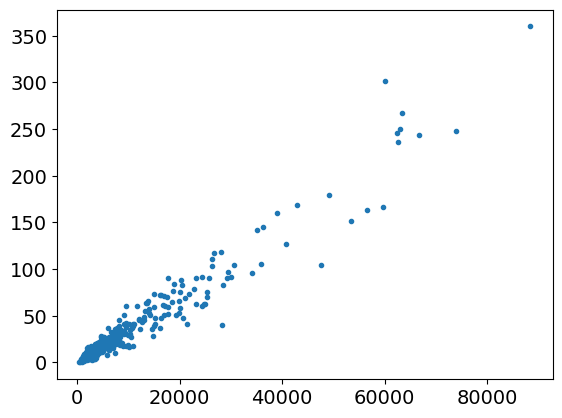

In [40]:
plt.scatter(cancer_dataset.exog, cancer_dataset.endog, marker='.')

In [41]:
# Statistically confirm that the data is heteroscedastic

In [42]:
from statsmodels.stats.diagnostic import het_breuschpagan, het_white

In [43]:
ols = sm.OLS(y, X)

In [44]:
ols_result = ols.fit()

In [45]:
ols_result.mse_model

729095.9995619444

In [46]:
# residuals of a LM are dependent on X

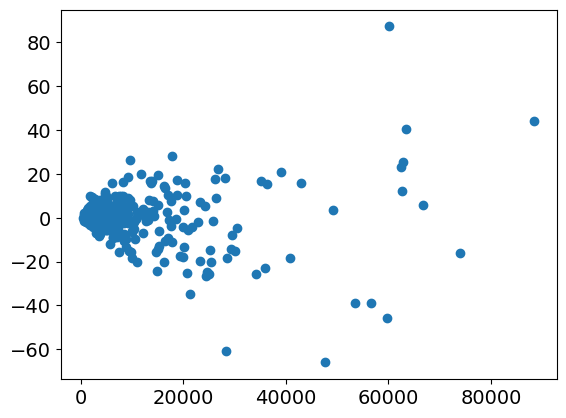

In [47]:
plt.scatter(X.population, ols_result.resid)

In [48]:
# statistical tests confirm this:

In [49]:
het_white(ols_result.resid, X)

(85.53997414283187,
 2.6621383623714153e-19,
 59.154620893488215,
 2.318630760683634e-22)

In [50]:
het_breuschpagan(ols_result.resid, X, robust=False)

(537.3616232659565,
 7.069820388982721e-119,
 117.16552931061003,
 2.9371544178871053e-23)

In [51]:
# Fitting models

In [52]:
# !pip install scikit-learn
import torch
import numpy as np
from sklearn.metrics import r2_score

from heteroscedastic import BetaGaussianMLP, BetaGaussianLM, _radius


In [53]:
torch.set_default_dtype(torch.double)
# torch.set_default_tensor_type(torch.DoubleTensor)

In [54]:
X_torch = torch.from_numpy(X.to_numpy())[:, 1].unsqueeze(-1)
y_torch = torch.from_numpy(y.to_numpy()).squeeze()

In [55]:
p = np.random.permutation(len(X_torch))
X_torch = X_torch[p]
y_torch = y_torch[p]

In [56]:
# leave out 10% of the points at the end: extrapolate

In [57]:
n_test = int(.5 * len(X_torch))
X_test, X_train = X_torch[-n_test:], X_torch[:-n_test]
y_test, y_train = y_torch[-n_test:], y_torch[:-n_test]

In [58]:
# normalize inputs
mu = X_train.mean()
std = torch.norm(X_train - mu)

In [59]:
mu

tensor(11039.1325)

In [60]:
X_train = (X_train - mu) / std
X_test = (X_test - mu) / std
X_torch = (X_torch - mu) / std

In [61]:
def save_for_plot(model):
    alpha = model.alpha
    model.eval()
    
    t = torch.linspace(X_torch.min(), X_torch.max() + .1, len(X_torch)).unsqueeze(-1)
    with torch.no_grad():
    
        y_pred, sigma_sq = model(t)
        std_pred = sigma_sq.sqrt()
    
    t = t.squeeze().numpy()
    y_pred = y_pred.squeeze().numpy()
    std_pred = std_pred.squeeze().numpy()

    if alpha == 1:
        # 95% confidence interval.
        a = 2*std_pred
    else:
        # 100% confidence interval.
        R = _radius(1, alpha)
        tau = (-R**2)/2 * (std_pred**2) ** (-(alpha-1) / (alpha+1))
        a = np.sqrt(-2 * tau * std_pred**2)
        
    return t, y_pred, a
    

def plot_model(t, y_pred, a, ax, which="support", fill_color='C0'):
    ax.plot(t, y_pred, color='C0', label="predicted mean")

    ax.fill_between(t,
                    y_pred - a,
                    y_pred + a,
                    alpha=0.2, color=fill_color, label="predicted {}".format(which))
       
    # Plot the truth
    ax.scatter(X_train.squeeze().numpy(), y_train.squeeze().numpy(), marker='.', color='C1', label='train')
    ax.scatter(X_test.squeeze().numpy(), y_test.squeeze().numpy(), marker='x', color='C2', label='test')

    ax.set_ylim(-10, 370)
    ax.set_xlim(None, t[-1])

def save_for_conf(model):
    alpha = model.alpha
    model.eval()
    
    # t_test = torch.linspace(X_test.min(), X_test.max() + .1, len(X_test)).unsqueeze(-1)
    with torch.no_grad():
    
        y_pred_test, sigma_sq_test = model(X_test)
        std_pred_test = sigma_sq_test.sqrt()
    
    # t_test = t_test.squeeze().numpy()
    y_pred_test = y_pred_test.squeeze().numpy()
    std_pred_test = std_pred_test.squeeze().numpy()

    if alpha == 1:
        # 95% confidence interval.
        a_test = 2*std_pred_test
    else:
        # 100% confidence interval.
        R_test = _radius(1, alpha)
        tau_test = (-R_test**2)/2 * (std_pred_test**2) ** (-(alpha-1) / (alpha+1))
        a_test = np.sqrt(-2 * tau_test * std_pred_test**2)

    return y_test, y_pred_test, a_test, X_test.squeeze().numpy()

In [62]:
# baseline

torch.manual_seed(42)
bl_model = BetaGaussianLM(input_size=1, uncertainty=False, heteroscedastic=False, alpha=None)
optimizer = torch.optim.LBFGS(bl_model.parameters(), lr=.01, max_iter=100)

n_epochs = 1000

for epoch in range(n_epochs):
    # Forward pass
    
    def closure():
        optimizer.zero_grad()
        bl_model.train()
        loss = bl_model.loss(X_train, y_train)
        loss.backward()
        return loss

    optimizer.step(closure)

# evaluate R^2
y_pred_train = bl_model.predict(X_train).detach().numpy()
y_pred_test = bl_model.predict(X_test).detach().numpy()
print("R2 train {:.3f} test {:.3f}".format(
    r2_score(y_pred_train, y_train.numpy()),
    r2_score(y_pred_test, y_test.numpy())))
    
print("w", bl_model.pred_y.weight.data, "b", bl_model.pred_y.bias.data)

R2 train 0.930 test 0.936
w tensor([[623.5984]]) b tensor([39.1656])


In [63]:
# try lbfgs

old_loss = np.inf

n_epochs = 1000

results = []
res_conf= []

for j, alpha in enumerate([1, 4/3, 1.5, 2]):
    torch.manual_seed(42)
    model = BetaGaussianLM(input_size=1, uncertainty=True, heteroscedastic=True, alpha=alpha)
    
    model.pred_y.weight.data[:] = bl_model.pred_y.weight
    model.pred_y.bias.data[:] = bl_model.pred_y.bias
    optimizer = torch.optim.LBFGS(model.parameters(), lr=.01, line_search_fn='strong_wolfe', max_iter=100)
    
    for epoch in range(n_epochs):
        
        def closure():
            optimizer.zero_grad()
            model.train()
            loss = model.loss(X_train, y_train)
            loss.backward()
            return loss
        
        optimizer.step(closure)
            
    # evaluate R^2
    model.eval()
    y_pred_train = model.predict(X_train).detach().numpy()
    y_pred_test = model.predict(X_test).detach().numpy()
    r2 = "R2 train {:.3f} test {:.3f}".format(
        r2_score(y_pred_train, y_train.numpy()),
        r2_score(y_pred_test, y_test.numpy()))
    
    print(alpha, r2)    
    results.append((alpha, save_for_plot(model), r2))
    res_conf.append(save_for_conf(model))
    np.savetxt(f"cancer_{alpha}_{r2}.csv", save_for_conf(model), delimiter=",")

1 R2 train 0.918 test 0.930
1.3333333333333333 R2 train 0.920 test 0.931
1.5 R2 train 0.920 test 0.931
2 R2 train 0.927 test 0.934


In [64]:
# y_pred_test

Text(0.5, 0, 'Standardized county population')

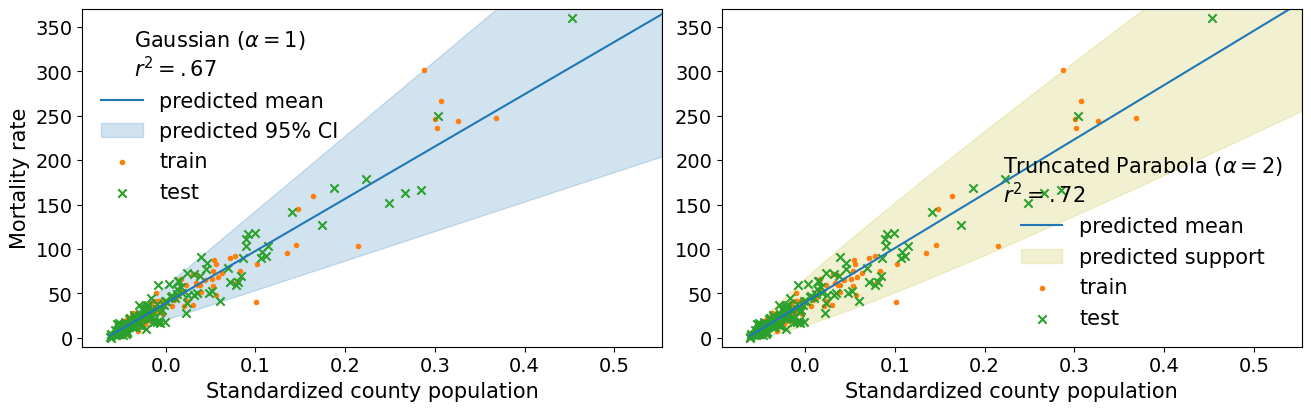

In [65]:
fig, (ax_gauss, ax_tp) = plt.subplots(1, 2, figsize=(13, 4), constrained_layout=True)

plt.rcParams['legend.title_fontsize'] = 15
plt.rcParams['legend.fancybox'] = False
plt.rcParams['legend.frameon'] = False
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

plot_model(*results[0][1], ax_gauss, "95% CI", fill_color='C0')
plot_model(*results[3][1], ax_tp, "support", fill_color='C8')
ax_gauss.legend(title="Gaussian ($\\alpha=1$)\n$r^2=.67$", fontsize=15)
ax_tp.legend(title="Truncated Parabola ($\\alpha=2$)\n$r^2=.72$", fontsize=15)
ax_gauss.set_ylabel("Mortality rate", fontsize=15)
ax_gauss.set_xlabel("Standardized county population", fontsize=15)
ax_tp.set_xlabel("Standardized county population", fontsize=15)
# plt.savefig("heteroscedastic.pdf")

In [66]:
res_conf[0][1][:, None]

array([[ 10.7963009 ],
       [ 61.23877594],
       [ 13.53354292],
       [ 13.92654744],
       [ 89.46960072],
       [ 12.1614745 ],
       [ 18.23236013],
       [ 18.42541498],
       [ 36.33814737],
       [ 37.60334614],
       [  9.86550072],
       [ 49.04529356],
       [ 47.03890206],
       [ 67.26484527],
       [ 57.57073374],
       [  6.11472073],
       [ 10.25161042],
       [ 21.49705558],
       [ 16.95681914],
       [  9.47594361],
       [ 26.21655725],
       [ 17.46703554],
       [ 97.42966597],
       [ 10.09302965],
       [ 46.34597303],
       [ 11.03072465],
       [ 24.6204073 ],
       [  9.35528432],
       [141.32206566],
       [  5.36318576],
       [ 53.23389438],
       [ 92.834271  ],
       [  7.48334173],
       [ 17.77385486],
       [ 52.66507204],
       [ 69.44360717],
       [ 40.88527863],
       [206.40223541],
       [ 12.630322  ],
       [ 10.24816302],
       [  8.07284852],
       [ 22.52438319],
       [ 26.24758392],
       [ 25

In [114]:
preds = res_conf[0][1][:, None]
sigmas = res_conf[0][2][:, None]
trues = res_conf[0][0][:, None].numpy()

In [115]:
pred_test = preds[100:]
true_test = trues[100:]
var_test = sigmas[100:]
# sigma_test = np.sqrt(var_test)

n_test = true_test.shape[0]

test_intervals = np.zeros((n_test,2))
test_intervals[:,0:1] = pred_test-var_test
test_intervals[:,1:] = pred_test+var_test
((true_test<=test_intervals[:,1:]) & (true_test>=test_intervals[:,0:1])).sum()/n_test

0.9

In [116]:
res_test_1 = pd.DataFrame({'true':true_test[:,0],
                         'pred': pred_test[:,0],
                         'width': 2*var_test[:,0]})
res_test_1['diff'] = np.abs(res_test.true - res_test.pred)
res_test_1['bin'] = pd.qcut(res_test['width'], 5, labels=False)

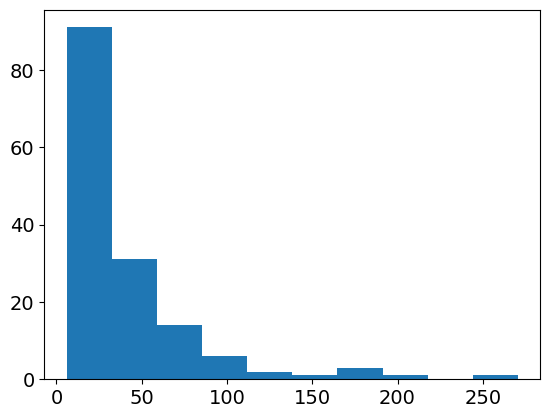

In [117]:
plt.hist(2*sigmas);

In [118]:
np.mean(2*sigmas)

39.485896746026484

In [119]:
preds = res_conf[3][1][:, None]
sigmas = res_conf[3][2][:, None]
trues = res_conf[3][0][:, None].numpy()

In [120]:
pred_test = preds[100:]
true_test = trues[100:]
var_test = sigmas[100:]
# sigma_test = np.sqrt(var_test)

n_test = true_test.shape[0]

test_intervals = np.zeros((n_test,2))
test_intervals[:,0:1] = pred_test-var_test
test_intervals[:,1:] = pred_test+var_test
((true_test<=test_intervals[:,1:]) & (true_test>=test_intervals[:,0:1])).sum()/n_test

0.96

In [122]:
res_test = pd.DataFrame({'true':true_test[:,0],
                         'pred': pred_test[:,0],
                         'width': 2*var_test[:,0]})
res_test['diff'] = np.abs(res_test.true - res_test.pred)
res_test['bin'] = pd.qcut(res_test['width'], 5, labels=False)

Text(0.5, 1.0, 'LR')

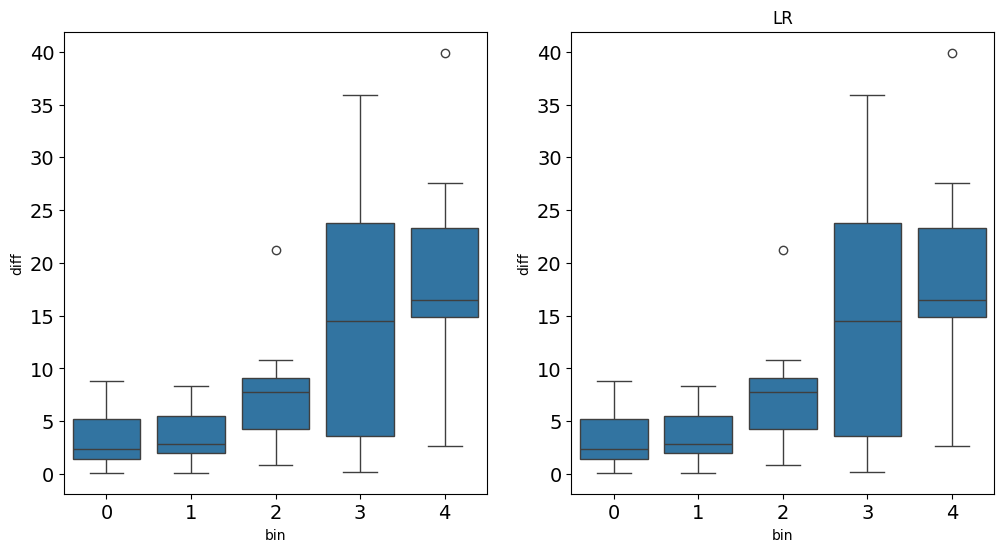

In [123]:
import seaborn as sns
fig,axs = plt.subplots(1,2,figsize=(12,6))
sns.boxplot(data=res_test, x='bin',y='diff',ax=axs[0])
sns.boxplot(data=res_test_1, x='bin',y='diff',ax=axs[1])
axs[1].set_title('LR')

In [84]:
res_test.groupby('bin').agg({'width':'min','diff':'mean'})

,width,diff
bin,,
0,3.654050,3.312353
1,15.502863,3.387830
2,21.685986,4.511822
3,25.519641,2.702914
4,35.479704,7.871751
5,41.507373,7.767569
6,52.062043,9.524240
7,69.674307,20.315705
8,88.635222,17.389255


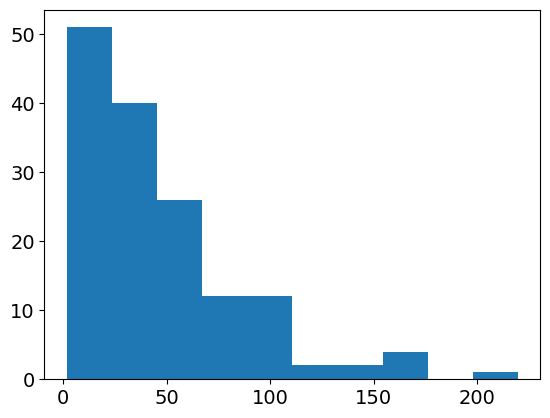

In [73]:
plt.hist(2*sigmas);

In [74]:
np.mean(2*sigmas)

47.55701401924022